# AirBnB Rental Price Predictions

### Goal: Create a model that will best predict AirBnB rental prices in New York City

#### Process:
* We first found data from a site called Inside Airbnb that compiles information directly from the site. It is not affiliated with AirBnB in any way, but the information is all direct and acurate.
* In addition to general AirBnB listing data, we thought "neighborhood value" would be solid factor in predicting rental price. We utilized the Zillow API to get the median house price for each neighborhood in every AirBnB listing.



#### There were 96 different listing columns! We chose the top 10 that we felt were the most correlated with rental price.

In [80]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

listings2 = pd.read_csv('listings.csv.gz', low_memory=False)
listings_short = listings2.filter(['price','beds', 'bathrooms','accommodates','property_type','neighbourhood','neighbourhood_group_cleansed','zipcode','review_scores_rating', 'room_type','number_of_reviews' ], axis=1)

In [79]:
listings2[listings2.price.replace('[\$,]', '', regex=True).astype(float) > 9500]

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
7765,4737930,https://www.airbnb.com/rooms/4737930,20181103152857,2018-11-03,Spanish Harlem Apt,"4 minute walk the 6 train. 2 bedroom, 1 bathro...","Economical, comfortable, convenient. Be advent...","4 minute walk the 6 train. 2 bedroom, 1 bathro...",none,East Harlem is a richly cultural neighborhood ...,...,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,0.02
8225,4890995,https://www.airbnb.com/rooms/4890995,20181103152857,2018-11-04,Experience NYC thru this Great Apt!,"This amazing apartment is in a safe, hip Brook...",NaN,"This amazing apartment is in a safe, hip Brook...",none,NaN,...,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,0.49
10957,7003697,https://www.airbnb.com/rooms/7003697,20181103152857,2018-11-03,Furnished room in Astoria apartment,1 room with a twin bed in a 2 bedroom apartmen...,1 furnished bedroom in a 2 bedroom Astoria apa...,1 room with a twin bed in a 2 bedroom apartmen...,none,"Quiet, extremely safe, no parking space but I ...",...,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,0.05
13148,8469166,https://www.airbnb.com/rooms/8469166,20181103152857,2018-11-04,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE NOT AVAILABLE NOT AVAILABLE NOT ...,none,NOT AVAILABLE,...,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,0.08
14848,9528920,https://www.airbnb.com/rooms/9528920,20181103152857,2018-11-03,"Quiet, Clean, Lit @ LES & Chinatown","This private room is clean, bright, comfortabl...","Renovated, bohemian 3-bedroom apartment with p...","This private room is clean, bright, comfortabl...",none,5-10 min walk to the Heart of Lower East Side ...,...,f,NaN,NaN,f,f,moderate,f,f,1,0.17
21616,13894339,https://www.airbnb.com/rooms/13894339,20181103152857,2018-11-03,Luxury 1 bedroom apt. -stunning Manhattan views,Our luxury 1 bedroom comfortably fits 3 guests...,"Our space is modern and bright, including a ki...",Our luxury 1 bedroom comfortably fits 3 guests...,none,Greenpoint is a hot neighborhood with great ba...,...,f,NaN,NaN,f,f,moderate,f,f,1,0.22
37514,22436899,https://www.airbnb.com/rooms/22436899,20181103152857,2018-11-04,1-BR Lincoln Center,"One bedroom, great neighborhood, steps away fr...",NaN,"One bedroom, great neighborhood, steps away fr...",none,NaN,...,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,NaN


In [69]:
listings_short = listings2.filter(['price','beds', 'bathrooms','accommodates','property_type','neighbourhood','neighbourhood_group_cleansed','zipcode','review_scores_rating', 'room_type','number_of_reviews' ], axis=1)
listings_short.head()

,price,beds,bathrooms,accommodates,property_type,neighbourhood,neighbourhood_group_cleansed,zipcode,review_scores_rating,room_type,number_of_reviews
0,$59.00,1.0,NaN,2,Apartment,NaN,Brooklyn,11221,73.0,Private room,14
1,$59.00,3.0,1.0,3,Apartment,Harlem,Manhattan,10026,93.0,Private room,174
2,$149.00,3.0,1.0,4,Apartment,Kensington,Brooklyn,11218,98.0,Private room,9
3,$225.00,1.0,1.0,2,Apartment,Midtown,Manhattan,10018,95.0,Entire home/apt,38
4,$89.00,1.0,1.0,4,House,Red Hook,Brooklyn,11231,79.0,Private room,22


In [70]:
import requests

#Connect to Zillow API, grab zipcodes and "zindex", which is median housing price per zipcode
r = requests.get("http://www.zillow.com/webservice/GetRegionChildren.htm?zws-id=X1-ZWz188d4jlv3m3_9k5bc&state=ny&city=new_york&childtype=zipcode")
from bs4 import BeautifulSoup
soup = BeautifulSoup(r.content)
zip_zindex = soup.findAll(['name', 'zindex'])
zipcode_list = soup.findAll('name')
median_prices_list = soup.findAll('zindex')

#Create a dictionary of dictionaries for zipcode and median house price. Not every zipcode had a Zindex listed.
zipcodes={}
for element in zip_zindex:
    if element in zipcode_list:
        zipcodes[element.contents[0]]={'zipcode':element.contents}
        lastzip = element.contents
    if element in median_prices_list:
        zipcodes[lastzip[0]]={'med_zillow_price': element.contents[0]}

#Turn that dictionary of dictionaries into a Dataframe
import pandas as pd
df = pd.DataFrame(zipcodes)
data = df.T
data["zip"]=data.index
data2 = data.drop(columns = 'zipcode')     

#Join the zipcode/zindex DataFrame to the original AirBnB DataFrame
full_data = data2.set_index('zip').join(listings_short.set_index('zipcode'))

### Now we have a full table of AirBnB columns and median household price for every neighborhood the listing is in.

In [9]:
full_data.head()

,med_zillow_price,price,beds,bathrooms,accommodates,property_type,neighbourhood,neighbourhood_group_cleansed,review_scores_rating,room_type,number_of_reviews
10001,2188500,$150.00,3.0,1.0,4.0,Apartment,Chelsea,Manhattan,89.0,Entire home/apt,394.0
10001,2188500,$123.00,1.0,1.0,2.0,Apartment,Chelsea,Manhattan,92.0,Private room,356.0
10001,2188500,$130.00,1.0,1.0,2.0,Apartment,Chelsea,Manhattan,96.0,Entire home/apt,19.0
10001,2188500,$239.00,1.0,1.0,2.0,Apartment,NaN,Manhattan,99.0,Entire home/apt,26.0
10001,2188500,$400.00,1.0,1.0,3.0,Apartment,NaN,Manhattan,96.0,Entire home/apt,26.0


In [81]:
import seaborn as sns
removed_null = full_data.dropna()

In [82]:
#Drop all null values, and turn all numerical variables into float types instead of objects.
airbnb = full_data.dropna()
airbnb['price'] = airbnb.price.replace('[\$,]', '', regex=True).astype(float)
airbnb['med_zillow_price'] = airbnb.med_zillow_price.apply(pd.to_numeric, errors='coerce')
airbnb['borough'] = airbnb['neighbourhood_group_cleansed']
airbnb.drop(columns = ['neighbourhood_group_cleansed'])

,med_zillow_price,price,beds,bathrooms,accommodates,property_type,neighbourhood,review_scores_rating,room_type,number_of_reviews,borough
10001,2188500,150.0,3.0,1.0,4.0,Apartment,Chelsea,89.0,Entire home/apt,394.0,Manhattan
10001,2188500,123.0,1.0,1.0,2.0,Apartment,Chelsea,92.0,Private room,356.0,Manhattan
10001,2188500,130.0,1.0,1.0,2.0,Apartment,Chelsea,96.0,Entire home/apt,19.0,Manhattan
10001,2188500,250.0,1.0,1.0,2.0,Apartment,Chelsea,96.0,Entire home/apt,18.0,Manhattan
10001,2188500,226.0,2.0,1.0,2.0,Apartment,Chelsea,90.0,Entire home/apt,26.0,Manhattan
10001,2188500,225.0,2.0,1.0,4.0,Apartment,Chelsea,95.0,Entire home/apt,53.0,Manhattan
10001,2188500,310.0,2.0,1.0,4.0,Apartment,Chelsea,93.0,Entire home/apt,266.0,Manhattan
10001,2188500,135.0,1.0,2.0,3.0,Apartment,Flatiron District,93.0,Private room,199.0,Manhattan
10001,2188500,145.0,1.0,2.0,3.0,Apartment,Flatiron District,92.0,Private room,132.0,Manhattan
10001,2188500,139.0,1.0,1.0,4.0,Apartment,Chelsea,89.0,Entire home/apt,23.0,Manhattan


In [12]:
airbnb.price.describe()

count    23742.000000
mean       135.392090
std        223.046817
min          0.000000
25%         65.000000
50%        100.000000
75%        155.000000
max      10000.000000
Name: price, dtype: float64

### I ran my model a few times, and it really wasn't looking great. 

Turns out it was because there a few outliers for people who listed their homes for thousands of dollars - so let's limit the listings to those under 300 dollars (still well above 75% of all listings), all neighborhoods that have less than 100 listings, and all property types that have less than 50 listings.

In [84]:
#Takes all neighborhoods with more than 200 listings
airbnb = airbnb.groupby('neighbourhood').filter(lambda x: len(x) >= 100)
#Takes all property types with more than 50 listings
airbnb = airbnb.groupby('property_type').filter(lambda x: len(x) >= 50)
#Only list properties that are $300 or less, which would include over 75% of our entire dataset.
airbnb = airbnb[airbnb['price'] <= 300]

In [85]:
airbnb.price.describe()

count    19936.000000
mean       114.067867
std         61.615961
min          0.000000
25%         65.000000
50%         99.000000
75%        150.000000
max        300.000000
Name: price, dtype: float64

In [86]:
airbnb['property_type'].value_counts()

Apartment             16085
House                  1699
Townhouse               772
Loft                    573
Condominium             460
Serviced apartment      161
Guest suite             132
Boutique hotel           54
Name: property_type, dtype: int64

## Let's visualize some of our features

This will give us an idea of how each feature might impact our price predictions!


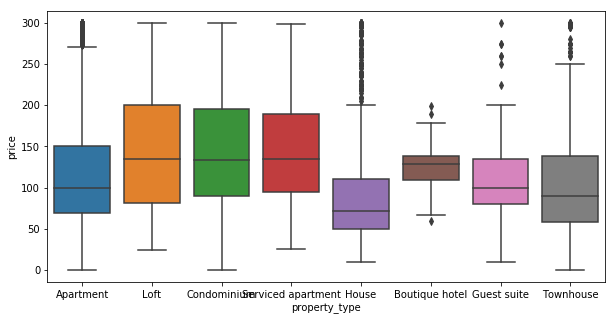

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
# sns.boxplot(y='price', x='property_type', data = airbnb.loc[airbnb['price'] <= 500.00])
sns.boxplot(y='price', x='property_type', data = airbnb)
plt.rcParams['figure.figsize']=(10,5)

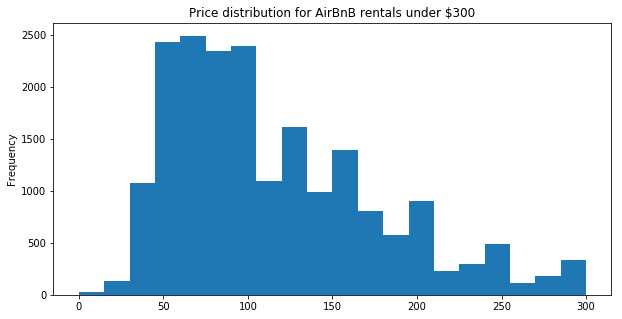

In [96]:
#price distrobution for AirBnB rentals
airbnb['price'].plot(kind = 'hist', bins=20, title = "Price distribution for AirBnB rentals under $300")
plt.rcParams['figure.figsize']=(10,5)

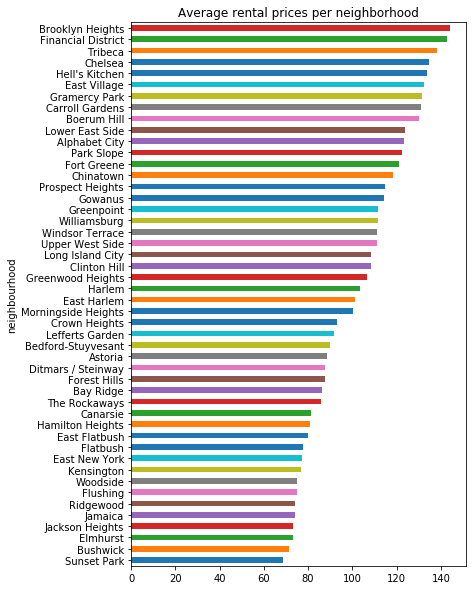

In [62]:
neighb_means = airbnb.groupby('neighbourhood')['price'].mean()
neighb_means.sort_values(ascending = True).plot(x='neighbourhood', y='price', kind='barh', 
                                                     title = "Average rental prices per neighborhood", figsize = (6, 10), sort_columns = True)


## Here are a bunch of ways to look at how all of our numerical variables correlate with each other

In [104]:
airbnb.corr()

,med_zillow_price,price,beds,bathrooms,accommodates,review_scores_rating,number_of_reviews
med_zillow_price,1.000000,0.315640,-0.038474,-0.050888,-0.017055,0.005606,-0.027607
price,0.315640,1.000000,0.423092,0.037944,0.544827,0.082408,0.019634
beds,-0.038474,0.423092,1.000000,0.190146,0.791838,-0.024366,0.107082
bathrooms,-0.050888,0.037944,0.190146,1.000000,0.155362,-0.028615,-0.019345
accommodates,-0.017055,0.544827,0.791838,0.155362,1.000000,-0.016813,0.133230
review_scores_rating,0.005606,0.082408,-0.024366,-0.028615,-0.016813,1.000000,0.015177
number_of_reviews,-0.027607,0.019634,0.107082,-0.019345,0.133230,0.015177,1.000000


In [98]:
def remove_apostrophe(dataframe):
    dataframe.columns = [x.replace("'","") for x in dataframe.columns]
    
def remove_period(dataframe):
    dataframe.columns = [x.replace(".","") for x in dataframe.columns]
    
def remove_dash(dataframe):
    dataframe.columns = [x.replace("-","") for x in dataframe.columns]
    
def remove_slash(dataframe):
    dataframe.columns = [x.replace("/","") for x in dataframe.columns]
    
def remove_spaces(dataframe):
    dataframe.columns = [x.replace(" ","") for x in dataframe.columns]
    
remove_apostrophe(airbnb)
remove_period(airbnb)
remove_dash(airbnb)
remove_slash(airbnb)
remove_spaces(airbnb)

In [99]:
abs(airbnb.corr())>0.75

,med_zillow_price,price,beds,bathrooms,accommodates,review_scores_rating,number_of_reviews
med_zillow_price,True,False,False,False,False,False,False
price,False,True,False,False,False,False,False
beds,False,False,True,False,True,False,False
bathrooms,False,False,False,True,False,False,False
accommodates,False,False,True,False,True,False,False
review_scores_rating,False,False,False,False,False,True,False
number_of_reviews,False,False,False,False,False,False,True


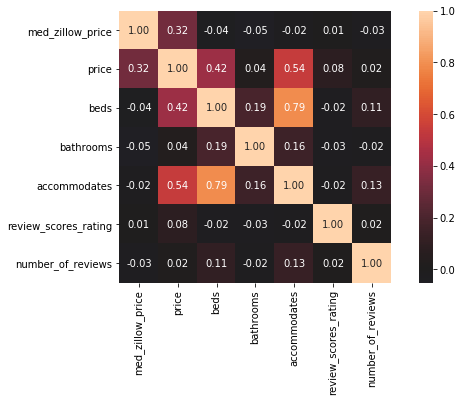

In [102]:
sns.heatmap(airbnb.corr(), center=0, cbar = True, annot=True, square = True, fmt = '.2f');

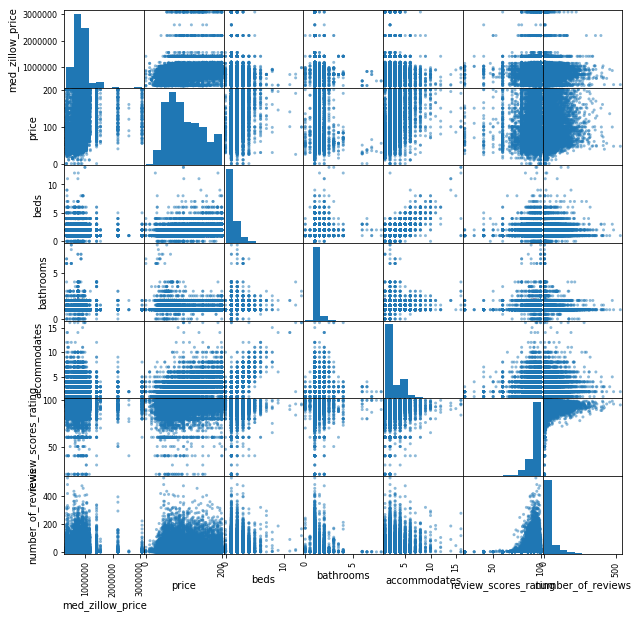

In [25]:
pd.plotting.scatter_matrix(airbnb,figsize  = [10, 10]);

### Include the Categorical Variables.

Because Regression Analysis can only use Numerical Values (because you can't chart "loft" vs "townhouse"), we include categorical variables by creating "dummy" variables. This turns category values in into either ones or zeroes.

In [106]:
#Get dummy variables for all of our categorial variables. That's neighborhoods, boroughs, and property_types
neighborhoods = pd.get_dummies(airbnb["neighbourhood"], prefix="hood", drop_first = True)
boroughs = pd.get_dummies(airbnb['borough'], prefix = "borough", drop_first = True)
property_type = pd.get_dummies(airbnb['property_type'], prefix = "type", drop_first = True)
beds = pd.get_dummies(airbnb['beds'], prefix = "beds", drop_first = True)
bathrooms = pd.get_dummies(airbnb['bathrooms'], prefix = "bathrooms", drop_first = True)
price = airbnb['price']
med_zillow_price = airbnb['med_zillow_price']
accommodates = airbnb['accommodates']
review_scores_rating = airbnb['review_scores_rating']
number_of_reviews = airbnb['number_of_reviews']
#create a dataframe with categorial dummy variables and numerical variables
data_fin = pd.concat([boroughs, neighborhoods, property_type, price, beds, bathrooms, med_zillow_price, accommodates, review_scores_rating, number_of_reviews], axis=1)

In [107]:
data_fin.head()

,borough_Manhattan,borough_Queens,hood_Astoria,hood_Bay Ridge,hood_Bedford-Stuyvesant,hood_Boerum Hill,hood_Brooklyn Heights,hood_Bushwick,hood_Canarsie,hood_Carroll Gardens,...,bathrooms_4.0,bathrooms_6.0,bathrooms_6.5,bathrooms_7.0,bathrooms_7.5,bathrooms_8.0,med_zillow_price,accommodates,review_scores_rating,number_of_reviews
10001,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2188500,4.0,89.0,394.0
10001,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2188500,2.0,92.0,356.0
10001,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2188500,2.0,96.0,19.0
10001,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2188500,2.0,96.0,18.0
10001,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2188500,2.0,90.0,26.0


In [108]:
def remove_apostrophe(dataframe):
    dataframe.columns = [x.replace("'","") for x in dataframe.columns]
    
def remove_period(dataframe):
    dataframe.columns = [x.replace(".","") for x in dataframe.columns]
    
def remove_dash(dataframe):
    dataframe.columns = [x.replace("-","") for x in dataframe.columns]
    
def remove_slash(dataframe):
    dataframe.columns = [x.replace("/","") for x in dataframe.columns]

def remove_spaces(dataframe):
    dataframe.columns = [x.replace(" ","") for x in dataframe.columns]
    
remove_apostrophe(data_fin)
remove_period(data_fin)
remove_dash(data_fin)
remove_slash(data_fin)
remove_spaces(data_fin)

In [109]:
outcome = 'price'
predictors = data_fin.drop('price', axis=1)
pred_sum = "+".join(predictors.columns)
formula = outcome + " ~ " + pred_sum

# model2.summary()

In [111]:
from sklearn.linear_model import LinearRegression
#Uses the Feature Ranking w/ Recursive Feature Elimination Feature Selection
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

#Choose n top features based on p-values
linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 5)
selector = selector.fit(predictors, data_fin["price"])

#Responds with variables and whether they meet top n features or not
#selector.support_ 
#Responds with ranking of variables
#selector.ranking_
# estimators = selector.estimator_
# print(estimators.coef_)
# print(estimators.intercept_)

Let's create our base model. This includes every single feature (both numerical and categorical), including every single neighborhood, borough, number of bathrooms, etc).

In [112]:
#Include every variable as a feature
features = data_fin.drop('price', axis=1)
#Make "price" our Target, or Y
target = data_fin.price

In [113]:
data_fin.columns

Index(['borough_Manhattan', 'borough_Queens', 'hood_Astoria', 'hood_BayRidge',
       'hood_BedfordStuyvesant', 'hood_BoerumHill', 'hood_BrooklynHeights',
       'hood_Bushwick', 'hood_Canarsie', 'hood_CarrollGardens', 'hood_Chelsea',
       'hood_Chinatown', 'hood_ClintonHill', 'hood_CrownHeights',
       'hood_DitmarsSteinway', 'hood_EastFlatbush', 'hood_EastHarlem',
       'hood_EastNewYork', 'hood_EastVillage', 'hood_Elmhurst',
       'hood_FinancialDistrict', 'hood_Flatbush', 'hood_Flushing',
       'hood_ForestHills', 'hood_FortGreene', 'hood_Gowanus',
       'hood_GramercyPark', 'hood_Greenpoint', 'hood_GreenwoodHeights',
       'hood_HamiltonHeights', 'hood_Harlem', 'hood_HellsKitchen',
       'hood_JacksonHeights', 'hood_Jamaica', 'hood_Kensington',
       'hood_LeffertsGarden', 'hood_LongIslandCity', 'hood_LowerEastSide',
       'hood_MorningsideHeights', 'hood_ParkSlope', 'hood_ProspectHeights',
       'hood_Ridgewood', 'hood_SunsetPark', 'hood_TheRockaways',
       'hood_Tr

In [120]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics

#Create training and testing set. Training is 80% of entire set
features = data_fin.drop('price', axis=1)
target = data_fin.price
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=32,test_size=0.2)

#Create Ordinary least squares Linear Regression.
lm = linear_model.LinearRegression()
#Fit that regression to our training set
model_base = lm.fit(X_train, y_train)

#Create y-value predictions based on our testing X-values set
y_pred = lm.predict(X_test)

print("Base MAE: " , metrics.mean_absolute_error(y_test, y_pred))
print("Base MSE: " , metrics.mean_squared_error(y_test, y_pred))
print("Base RMSE: " , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Base MAE:  33.2926313662754
Base MSE:  1962.7051966843912
Base RMSE:  44.302428789902606


### But what do these mean?
* __MAE__: Mean Absolute Error. This is an average of absolute differences between the target values and the predictions. The MAE is a linear score which means that all the individual differences are weighted equally in the average.


* __MSE__: Mean Squared Error. This is the average squared error of our predictions. For each point, it calculates square difference between the predictions and the target and then average those values. The higher the value, the worse (or less reliable) the model is. A zero would be a perfect model.


* __RMSE__: Root Mean Squared Error. This is just the square root of MSE!  The RMSE will always be larger or equal to the MAE; the greater difference between them, the greater the variance in the individual errors in the sample. If the RMSE=MAE, then all the errors are of the same magnitude

Text(0.5, 1.0, 'Regression line for Base Model')

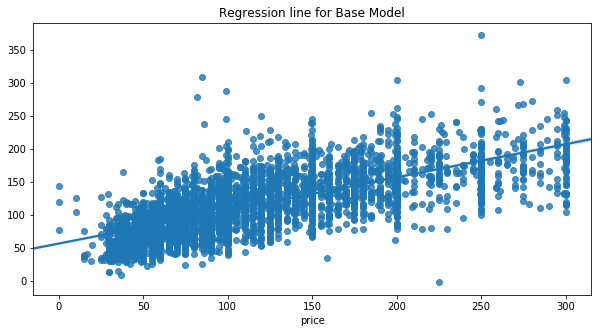

In [122]:
sns.regplot(y_test, y_pred).set_title('Regression line for Base Model')

Now that we have a baseline model that includes all of our features, let's pick and choose specific features that are quantifiably more relevant to our predictions. This method is called "Feature Selection", and there are several approaches to this.


In [123]:
from sklearn import preprocessing
from sklearn import pipeline
#Create training and testing set. Training is 80% of entire set
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=32,test_size=0.2)
scaler = preprocessing.StandardScaler()
#Take out all categorical variables, because there's no point in scaling 1's and 0's
scaler.fit(X_train.iloc[:,-6:])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [124]:
X_train.columns[-6:]

Index(['bathrooms_75', 'bathrooms_80', 'med_zillow_price', 'accommodates',
       'review_scores_rating', 'number_of_reviews'],
      dtype='object')

### Our first step is Feature Scaling. 

The ranges of our values in our data range from million of dollars (Zillow home prices) to number of bathrooms in a home, so we normalize the values so that each feature contributes proportiontely to the predicted value.


The method we are using to scale our features in this case is Standard Scaling, which subtracts the mean for each unit and divides by the standard deviation. If there's a value less than the mean, the scaled number will be negative.



In [125]:
#Create a new dataframe with new scaled numerical variables
features_scaled_train = pd.DataFrame(scaler.transform(X_train.iloc[:,-6:]), columns=X_train.columns[-6:], index = X_train.index)

#Add back in your categorical variables
features_scaled_train = pd.concat([X_train.iloc[:,:-6],features_scaled_train], axis=1)

features_scaled_train.head()

#if there's a value less than the mean, the scaled number will be negative. This is because the scaled number
#is z= (x-u)/s.
#x = value
#u = mean of training samples
#s = standard deviation
#Create a new dataframe with new scaled numerical variables
features_scaled_test = pd.DataFrame(scaler.transform(X_test.iloc[:,-6:]), columns=X_train.columns[-6:], index = X_test.index)
features_scaled_test = pd.concat([X_test.iloc[:,:-6],features_scaled_test], axis=1)
features_scaled_test.head()

,borough_Manhattan,borough_Queens,hood_Astoria,hood_BayRidge,hood_BedfordStuyvesant,hood_BoerumHill,hood_BrooklynHeights,hood_Bushwick,hood_Canarsie,hood_CarrollGardens,...,bathrooms_40,bathrooms_60,bathrooms_65,bathrooms_70,bathrooms_75,bathrooms_80,med_zillow_price,accommodates,review_scores_rating,number_of_reviews
11238,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-0.007919,-0.007919,-0.161162,0.154990,-0.611196,0.305271
11105,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,-0.007919,-0.007919,-0.573521,-0.474442,0.749406,-0.224060
10009,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-0.007919,-0.007919,0.639708,-0.474442,0.130951,-0.554892
11412,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,-0.007919,-0.007919,-1.418464,-0.474442,0.749406,-0.444615
10003,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-0.007919,-0.007919,1.723131,-1.103873,-2.590252,-0.576948


In [132]:


poly = preprocessing.PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
features_many_train = pd.DataFrame(poly.fit_transform(features_scaled_train), columns=poly.get_feature_names(features_scaled_train.columns))
features_many_train.head()
#preprocessing.PolynomialFeatures = Generate polynomial and interaction features.
#Generate a new feature matrix consisting of all polynomial combinations of the features with 
#degree less than or equal to the specified degree. For example, if an input sample is two dimensional 
#and of the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].
#poly.fit_transform = Fit to data, then transform it.

,borough_Manhattan,borough_Queens,hood_Astoria,hood_BayRidge,hood_BedfordStuyvesant,hood_BoerumHill,hood_BrooklynHeights,hood_Bushwick,hood_Canarsie,hood_CarrollGardens,...,med_zillow_price^2,med_zillow_price accommodates,med_zillow_price review_scores_rating,med_zillow_price number_of_reviews,accommodates^2,accommodates review_scores_rating,accommodates number_of_reviews,review_scores_rating^2,review_scores_rating number_of_reviews,number_of_reviews^2
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.070099,0.107774,-0.103573,-0.959109,0.165698,-0.159239,-1.474586,0.153031,1.417103,13.122705
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.006698,0.033313,-0.052135,0.023690,0.165698,-0.259317,0.117834,0.405832,-0.184411,0.083797
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,2.240628,-0.462461,-0.585564,-1.443126,0.095451,0.120859,0.297858,0.153031,0.377146,0.929477
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.061692,-0.101105,-0.116567,-0.088004,0.165698,0.191038,0.144228,0.220252,0.166284,0.125540
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.114736,-0.137882,0.257425,-0.207868,0.165698,-0.309357,0.249803,0.577568,-0.466380,0.376598


In [133]:
features_many_test = pd.DataFrame(poly.fit_transform(features_scaled_test), columns=poly.get_feature_names(features_scaled_test.columns))
features_many_test.head()

,borough_Manhattan,borough_Queens,hood_Astoria,hood_BayRidge,hood_BedfordStuyvesant,hood_BoerumHill,hood_BrooklynHeights,hood_Bushwick,hood_Canarsie,hood_CarrollGardens,...,med_zillow_price^2,med_zillow_price accommodates,med_zillow_price review_scores_rating,med_zillow_price number_of_reviews,accommodates^2,accommodates review_scores_rating,accommodates number_of_reviews,review_scores_rating^2,review_scores_rating number_of_reviews,number_of_reviews^2
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.145463,0.435661,-0.550244,-0.152822,0.165698,-0.209278,-0.058124,0.264320,0.073411,0.020389
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.028617,-0.068860,-0.287342,-0.103812,0.165698,0.691432,0.249803,2.885241,1.042389,0.376598
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.014480,-0.209495,-0.047073,0.060841,3.030991,0.681055,-0.880252,0.153031,-0.197790,0.255641
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.523686,0.741726,-0.072745,-0.412812,1.050549,-0.103033,-0.584689,0.010105,0.057344,0.325412
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.061692,0.254578,0.188762,-0.125582,1.050549,0.778950,-0.518231,0.577568,-0.384252,0.255641


In [134]:
from sklearn.feature_selection import VarianceThreshold

#Feature selector that removes all low-variance features.
#This feature selection algorithm looks only at the features (X), not the desired outputs (y), 
#and can thus be used for unsupervised learning.

thresholder = VarianceThreshold(threshold=.5)

def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]


In [135]:
features_selected_train = variance_threshold_selector(features_many_train)

In [136]:
# features_selected_train.head()
len(features_selected_train.columns)

36

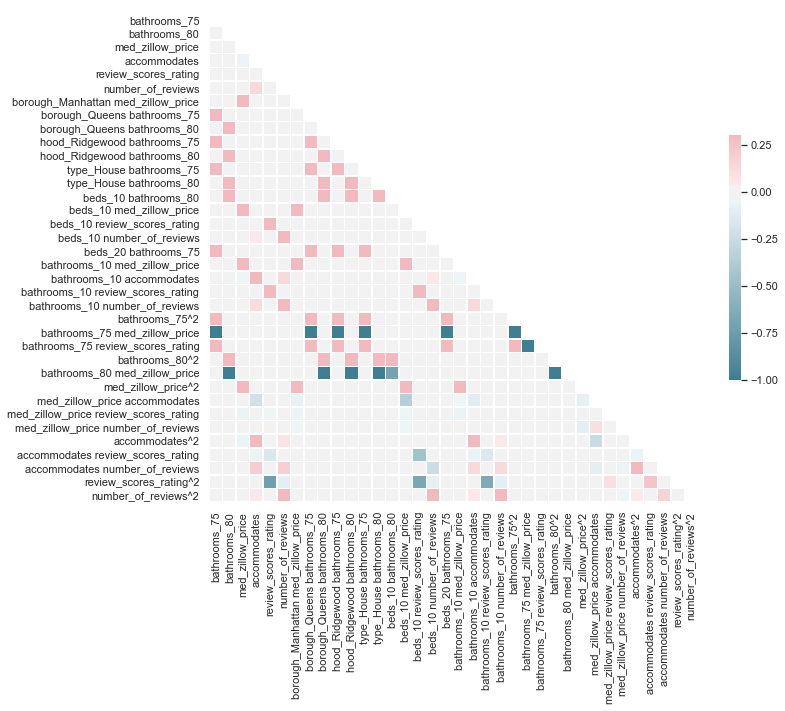

In [137]:
import seaborn as sns

sns.set(style="white")


# Compute the correlation matrix between selected features that have high variance
corr = features_selected_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [138]:
# Create correlation matrix, take absolute values of each correlation
corr_matrix = features_selected_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [139]:
to_drop

['borough_Queens bathrooms_75',
 'borough_Queens bathrooms_80',
 'hood_Ridgewood bathrooms_75',
 'hood_Ridgewood bathrooms_80',
 'type_House bathrooms_75',
 'type_House bathrooms_80',
 'beds_20 bathrooms_75',
 'bathrooms_10 med_zillow_price',
 'bathrooms_75^2',
 'bathrooms_75 med_zillow_price',
 'bathrooms_75 review_scores_rating',
 'bathrooms_80^2',
 'bathrooms_80 med_zillow_price']

In [140]:
features_selected_train.drop(columns=to_drop, inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [141]:
#SelectKBest = Select features according to the k highest scores.
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression

In [142]:
def information_selector(X, y, scoring, k=5):
    selector = SelectKBest(score_func=scoring, k=k)
    selector.fit(X, y)
    return X[X.columns[selector.get_support(indices=True)]]

In [143]:
#score each feature by mutual_info_regression

test = SelectKBest(score_func=mutual_info_regression, k=13)
fit = test.fit(features_selected_train, y_train)

In [144]:
features_selected_train[features_selected_train.columns[fit.get_support(indices=True)]].head()

,med_zillow_price,accommodates,beds_10 bathrooms_80,beds_10 med_zillow_price,beds_10 review_scores_rating,beds_10 number_of_reviews,bathrooms_10 accommodates,med_zillow_price^2,med_zillow_price accommodates,med_zillow_price review_scores_rating,accommodates^2,accommodates review_scores_rating,accommodates number_of_reviews
0,-0.264763,-0.407060,-0.011709,-0.264763,0.391192,3.622527,-0.407060,0.070099,0.107774,-0.103573,0.165698,-0.159239,-1.474586
1,-0.081839,-0.407060,-0.000000,-0.000000,0.000000,-0.000000,-0.407060,0.006698,0.033313,-0.052135,0.165698,-0.259317,0.117834
2,-1.496873,0.308951,-0.011709,-1.496873,0.391192,0.964094,0.308951,2.240628,-0.462461,-0.585564,0.095451,0.120859,0.297858
3,0.248378,-0.407060,-0.011709,0.248378,-0.469311,-0.354316,-0.407060,0.061692,-0.101105,-0.116567,0.165698,0.191038,0.144228
4,0.338727,-0.407060,-0.011709,0.338727,0.759979,-0.613676,-0.407060,0.114736,-0.137882,0.257425,0.165698,-0.309357,0.249803


In [145]:
features_selected_train = information_selector(features_selected_train, y_train, mutual_info_regression, k=13)

In [146]:
features_selected_train.head()

,med_zillow_price,accommodates,beds_10 bathrooms_80,beds_10 med_zillow_price,beds_10 review_scores_rating,beds_10 number_of_reviews,bathrooms_10 accommodates,med_zillow_price^2,med_zillow_price accommodates,med_zillow_price review_scores_rating,accommodates^2,accommodates review_scores_rating,accommodates number_of_reviews
0,-0.264763,-0.407060,-0.011709,-0.264763,0.391192,3.622527,-0.407060,0.070099,0.107774,-0.103573,0.165698,-0.159239,-1.474586
1,-0.081839,-0.407060,-0.000000,-0.000000,0.000000,-0.000000,-0.407060,0.006698,0.033313,-0.052135,0.165698,-0.259317,0.117834
2,-1.496873,0.308951,-0.011709,-1.496873,0.391192,0.964094,0.308951,2.240628,-0.462461,-0.585564,0.095451,0.120859,0.297858
3,0.248378,-0.407060,-0.011709,0.248378,-0.469311,-0.354316,-0.407060,0.061692,-0.101105,-0.116567,0.165698,0.191038,0.144228
4,0.338727,-0.407060,-0.011709,0.338727,0.759979,-0.613676,-0.407060,0.114736,-0.137882,0.257425,0.165698,-0.309357,0.249803


In [147]:
# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(features_selected_train, y_train)


In [148]:
features_selected_test = features_many_test[features_selected_train.columns]
y_pred = lm.predict(features_selected_test)

print("K Best Feature Selection MAE: " ,metrics.mean_absolute_error(y_test, y_pred))
print("K Best Feature Selection MSE: " , metrics.mean_squared_error(y_test, y_pred))
print("K Best Feature Selection RMSE: " , np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


K Best Feature Selection MAE:  27.88995905534085
K Best Feature Selection MSE:  1236.455168444332
K Best Feature Selection RMSE:  35.16326447365677


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


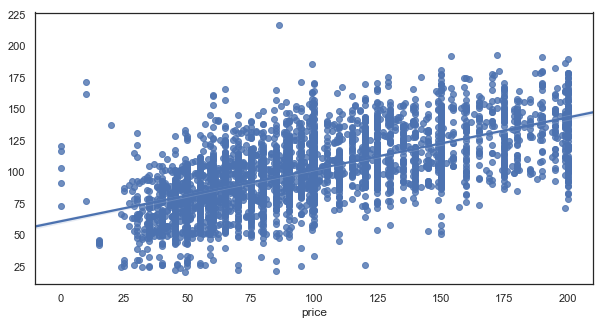

In [149]:
sns.regplot(y_test, y_pred)

In [151]:
## training the model
from sklearn.linear_model import Lasso


lassoReg = Lasso(alpha=0.05, normalize=True)

lassoReg.fit(X_train,y_train)

y_pred = lassoReg.predict(X_test)

#calculating mse

print('Lasso MSE:', metrics.mean_squared_error(y_test, y_pred))
print('Lasso RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#this many Standard Deviations away from the mean..?
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred))/ y_test.std())



coef = pd.DataFrame(data=lassoReg.coef_, index=X_train.columns )
model_coef = coef.sort_values(by=0).T

#model_coef.plot(kind='bar', title='Lasso Model Coefficients', legend=False, figsize=(16,8))


Lasso MSE: 1472.5974944148807
Lasso RMSE: 38.374438033864166
0.8376669926665681


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


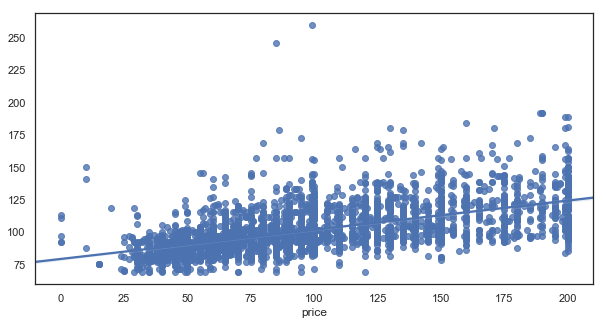

In [152]:
sns.regplot(y_test, y_pred)

In [153]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor


y = data_fin.price
x = data_fin.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=1)
rf = RandomForestRegressor(n_estimators=600, 
                               criterion='mse', 
                               random_state=3, 
                               n_jobs=-1)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
rmse_rf= (mean_squared_error(y_test,y_test_pred))**(1/2)

print('Random Forest RMSE: %.3f' % rmse_rf)
print('Random Forest R^2: %.3f' % (r2_score(y_test, y_test_pred)))

Random Forest RMSE: 35.132
Random Forest R^2: 0.413


# Most important features in Random Forest predictors

In [69]:
coefs_df = pd.DataFrame()
coefs_df['est_int'] = X_train.columns
coefs_df['coefs'] = rf.feature_importances_
coefs_df.sort_values('coefs', ascending=False).head(20)

,est_int,coefs
82,accommodates,0.287992
81,med_zillow_price,0.221082
84,number_of_reviews,0.172650
83,review_scores_rating,0.101196
69,bathrooms_10,0.013213
57,beds_20,0.011778
56,beds_10,0.011578
52,type_House,0.009659
50,type_Condominium,0.007725
53,type_Loft,0.007498


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


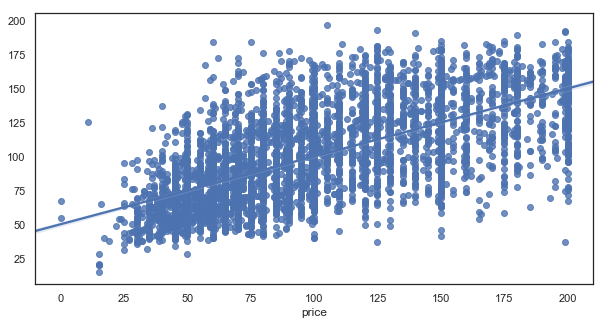

In [70]:
#Random Forest 
sns.regplot(y_test, y_test_pred)